# Data Loading & Classification - COVID-19


**Deep Learning and Its Applications to Signal and Image Processing and Analysis, 361-2-1120**

**Alon Finestein - alonfi@post.bgu.ac.il**

**Thomas Mendelson - thomasm@post.bgu.ac.il**

In the following assignment we will create a dataset and costum model for classification of pneumonia and COVID-19 cases.

**We will deal with imbalnced data, train a classification CNN model for 3 class classification (Normal,Bacterial, Covid-19), expirament with Transfer Learning and t-SNE**

The assignment will hopefully give you the tools needed to address real world datasets and help you with your own research challanges.

# Student's notes
**We work on our personal computers so we changed the code to support pc and not google colab env**



# Import Libraries

In [ ]:
# from google.colab import drive # If working with google colab
# drive.mount('/content/drive')

In [4]:
import torch
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from pathlib import Path

# 1. Load and Explore the Data


## 1.1 Load the Data

In order to address this classification problem we first need to create our dataset. In this section you will load the data from 2 different datasets and combine them into data for training and testing

The first dataset contains the covid 19 part of the data

The second dataset contians more then needed for this exercise, we will only use the healthy expamples (appears as Normal in the dataset) and those of the Bacterial subcatagory of Pneumonia  

### Load COVID-19 chest X-Ray

Clone COVID-19 X-Ray dataset repository

https://github.com/ieee8023/covid-chestxray-dataset

The data consists of X-ray images of pneumonia cases gathered from different sources.

Please refer to the link to read about the given data.
Additional info can be found in the dataset paper :
https://arxiv.org/abs/2003.11597

**Studen's notes - we executed this on the terminal**


In [ ]:
#We can use "!" to run bash commands in google colab
#The following command will download the latest available data from the git repository
# !git clone https://github.com/ieee8023/covid-chestxray-dataset.github

Set images and metadata files path and examine data

In [5]:
covid_images_path = Path("covid-chestxray-dataset/images")
covid_metadata_path = Path("covid-chestxray-dataset/metadata.csv")

We use pandas to convert the metadata CSV to a dataframe object.

If you are unfamiliar with pandas please refer to:

https://pandas.pydata.org/pandas-docs/stable/getting_started/10min.html

In [13]:
covid_metadata = pd.read_csv(covid_metadata_path)

KeyboardInterrupt: 

A look at the metadata:

You can read the paper for description of the data contents.

In [14]:
covid_metadata.head(10)

KeyboardInterrupt: 

In [9]:
#List the images
list(covid_images_path.glob("*"))[0:10]

[WindowsPath('covid-chestxray-dataset/images/000001-1.jpg'),
 WindowsPath('covid-chestxray-dataset/images/000001-1.png'),
 WindowsPath('covid-chestxray-dataset/images/000001-10.jpg'),
 WindowsPath('covid-chestxray-dataset/images/000001-11.jpg'),
 WindowsPath('covid-chestxray-dataset/images/000001-12.jpg'),
 WindowsPath('covid-chestxray-dataset/images/000001-13.jpg'),
 WindowsPath('covid-chestxray-dataset/images/000001-14.jpg'),
 WindowsPath('covid-chestxray-dataset/images/000001-15.jpg'),
 WindowsPath('covid-chestxray-dataset/images/000001-17.jpg'),
 WindowsPath('covid-chestxray-dataset/images/000001-18.jpg')]

Visualize some cases

In [ ]:
# Original code that did not work in my notebook

# plt.rcParams["figure.figsize"] = (20,10)
# for index, case in covid_metadata.head(5).iterrows():
#   plt.subplot(2,3,index+1)
#   image_path = covid_images_path / case["filename"]
#   # plt.figure()
#   plt.title("Patient ID: {0}, finding: {1},\n view: {2}, offset: {3}".format(case["patientid"],case["finding"],case["view"],case["offset"]))
#   plt.imshow(plt.imread(image_path),cmap='gray')
# plt.show()

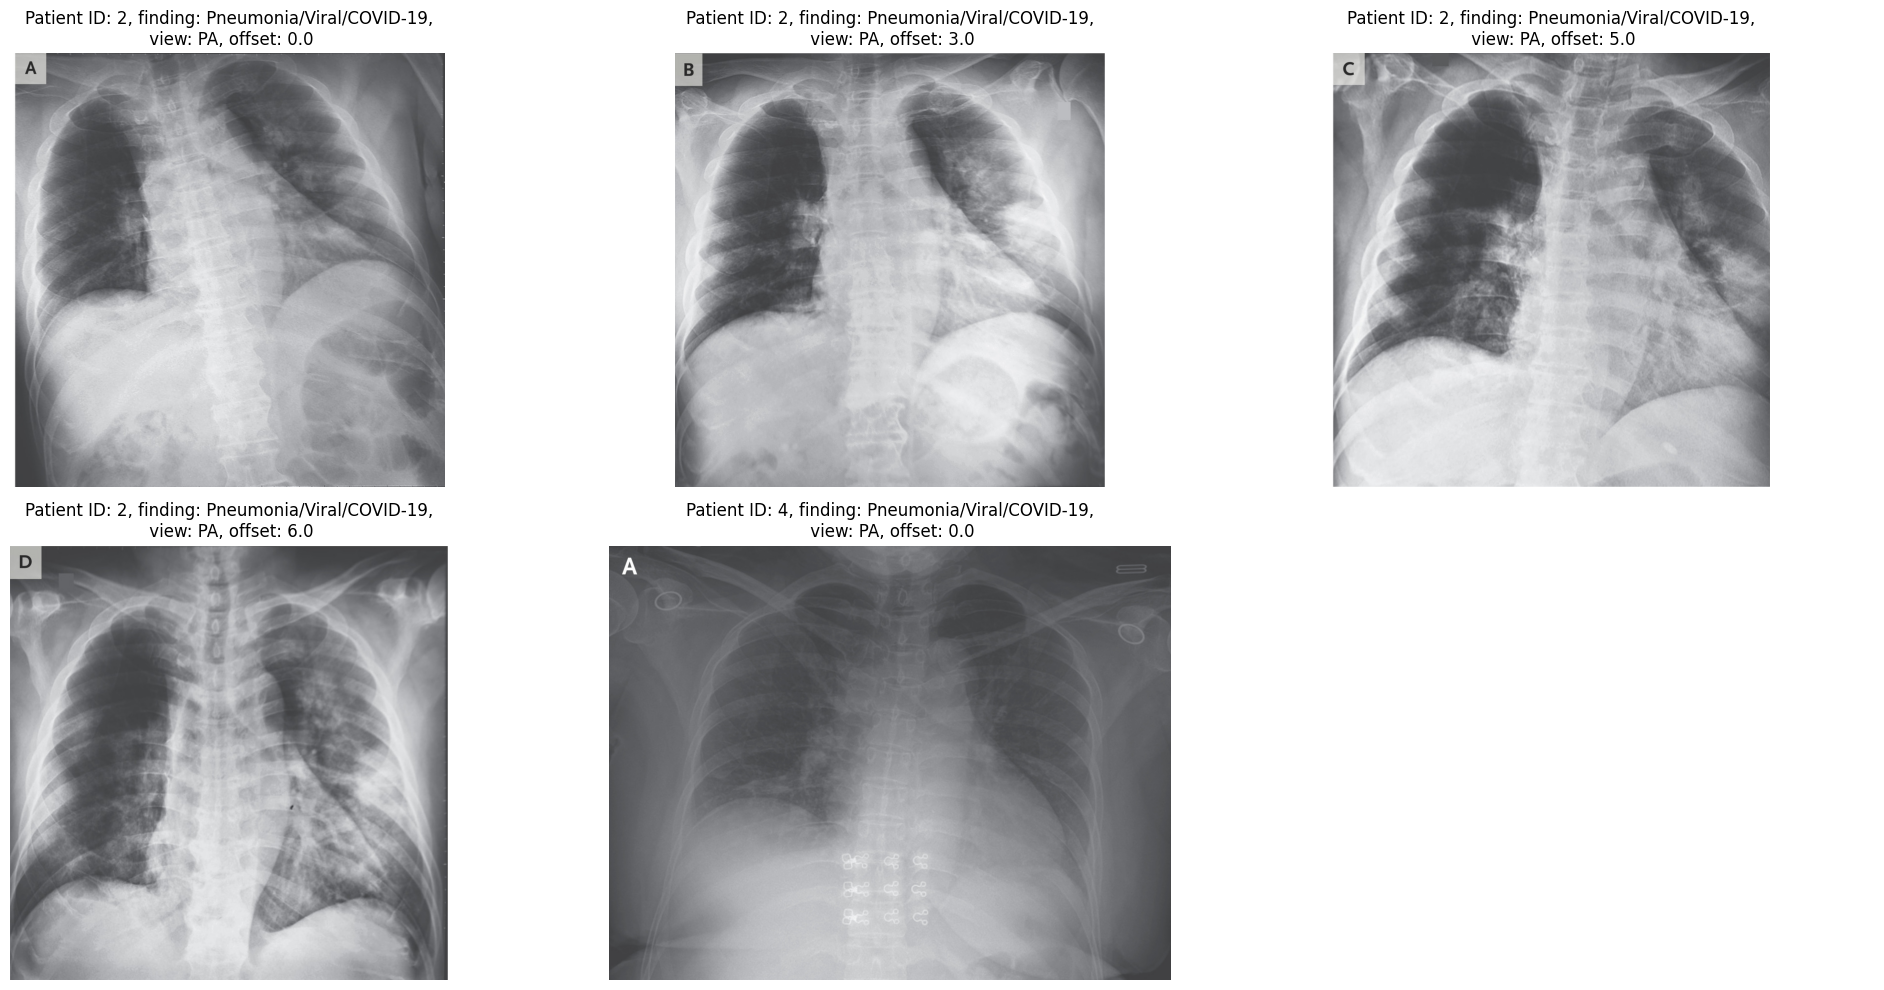

In [11]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))  # Create a 2x3 grid of subplots
axes = axes.flatten()  # Make it easy to index with a flat loop

for i, (_, case) in enumerate(covid_metadata.head(5).iterrows()):
    image_path = covid_images_path / case["filename"]
    image = plt.imread(image_path)

    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(
        "Patient ID: {0}, finding: {1},\n view: {2}, offset: {3}".format(
            case["patientid"], case["finding"], case["view"], case["offset"]
        )
    )
    axes[i].axis("off")

# Hide any unused subplot (e.g., the 6th one if you only show 5 images)
for j in range(i+1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

#### Filter Covid-19 Dataset
Write your own code to filter the metadata dataframe to contain only posteroanterior - "PA" (back-to-front) views.

Return a dataframe that contains finding/full filepath as in the following figure:
<table>
  <tr>
    <th></th>
    <th>finding</th>
    <th>filepath</th>
  </tr>
  <tr>
    <td>0</td>
    <td>Pneumonia/Viral/COVID-19</td>
    <td>some/file/path</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Pneumonia/Viral/COVID-19</td>
    <td>another/file/path</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pneumonia/Viral/SARS</td>
    <td>some/other/file/path</td>
  </tr>
    <tr>
    <td>...</td>
    <td>...</td>
    <td>...</td>
  </tr>
        <tr>
    <td>...</td>
    <td>...</td>
    <td>...</td>
  </tr>
       <tr>
    <td>...</td>
    <td>...</td>
    <td>...</td>
  </tr>
        <tr>
    <td>...</td>
    <td>...</td>
    <td>...</td>
  </tr>
       <tr>
    <td>...</td>
    <td>...</td>
    <td>...</td>
  </tr>
       <tr>
    <td>...</td>
    <td>...</td>
    <td>...</td>
  </tr>
        <tr>
    <td>...</td>
    <td>...</td>
    <td>...</td>
  </tr>
</table>

In [27]:
# Initialize an empty list to collect rows
filtered_entries = []

for _, entry in covid_metadata.iterrows():
    if entry['view'] != "PA":
        continue
    filepath = f"covid-chestxray-dataset/{entry['folder']}/{entry['filename']}"
    filtered_entries.append({
        "finding": entry['finding'],
        "filepath": filepath
    })

# Create the DataFrame after filtering
filtered_db = pd.DataFrame(filtered_entries)

# Show new dataframe
filtered_db.head(30)

,finding,filepath
0,Pneumonia/Viral/COVID-19,covid-chestxray-dataset/images/auntminnie-a-20...
1,Pneumonia/Viral/COVID-19,covid-chestxray-dataset/images/auntminnie-b-20...
2,Pneumonia/Viral/COVID-19,covid-chestxray-dataset/images/auntminnie-c-20...
3,Pneumonia/Viral/COVID-19,covid-chestxray-dataset/images/auntminnie-d-20...
4,Pneumonia/Viral/COVID-19,covid-chestxray-dataset/images/nejmc2001573_f1...
5,Pneumonia/Viral/COVID-19,covid-chestxray-dataset/images/nejmc2001573_f1...
6,Pneumonia,covid-chestxray-dataset/images/ARDSSevere.png
7,Pneumonia/Viral/COVID-19,covid-chestxray-dataset/images/lancet-case2a.jpg
8,Pneumonia/Viral/COVID-19,covid-chestxray-dataset/images/lancet-case2b.jpg
9,Pneumonia/Viral/SARS,covid-chestxray-dataset/images/SARS-10.1148rg....


Filter your dataframe so it contains only COVID-19 cases:

In [32]:
filtered_db_covid = filtered_db[filtered_db["finding"] == "Pneumonia/Viral/COVID-19"]
# Show new dataframe
filtered_db_covid.head(30)

,finding,filepath
0,Pneumonia/Viral/COVID-19,covid-chestxray-dataset/images/auntminnie-a-20...
1,Pneumonia/Viral/COVID-19,covid-chestxray-dataset/images/auntminnie-b-20...
2,Pneumonia/Viral/COVID-19,covid-chestxray-dataset/images/auntminnie-c-20...
3,Pneumonia/Viral/COVID-19,covid-chestxray-dataset/images/auntminnie-d-20...
4,Pneumonia/Viral/COVID-19,covid-chestxray-dataset/images/nejmc2001573_f1...
5,Pneumonia/Viral/COVID-19,covid-chestxray-dataset/images/nejmc2001573_f1...
7,Pneumonia/Viral/COVID-19,covid-chestxray-dataset/images/lancet-case2a.jpg
8,Pneumonia/Viral/COVID-19,covid-chestxray-dataset/images/lancet-case2b.jpg
12,Pneumonia/Viral/COVID-19,covid-chestxray-dataset/images/1-s2.0-S0140673...
13,Pneumonia/Viral/COVID-19,covid-chestxray-dataset/images/nCoV-radiol.202...


#### Train Test Split
split the data into train and test data.

In [46]:
from sklearn.model_selection import train_test_split
X = filtered_db_covid['filepath']  # features
Y = filtered_db_covid['finding']   # target

# Split: 80% train, 20% test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
print(X_train.shape, X_test.shape)

(156,) (40,)


### Load Pneumonia and Normal chest X-Ray

This dataset contains 5,856 validated Chest X-Ray images. The images are split into a training set and a testing set of independent patients. Images are labeled as (disease:NORMAL/BACTERIA/VIRUS)-(randomized patient ID)-(image number of a patient).


For more information [chest X-Ray](https://www.kaggle.com/datasets/tolgadincer/labeled-chest-xray-images)

##### Installing the [Kaggle API](https://github.com/Kaggle/kaggle-api) in Colab

In [ ]:
# !pip install kaggle

##### Authenticating with Kaggle using kaggle.json

Navigate to https://www.kaggle.com. Then go to the [Account tab of your user profile](https://www.kaggle.com/me/account) and select Create API Token. This will trigger the download of kaggle.json, a file containing your API credentials.

Then run the cell below to upload kaggle.json to your Colab runtime.

In [ ]:
# from google.colab import files
# uploaded = files.upload()
#
# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))
#
# # Then move kaggle.json into the folder where the API expects to find it.
# !mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

##### Using the Kaggle API

For a more complete list of what you can do with the API, visit https://github.com/Kaggle/kaggle-api.

##### Downloading Pneumonia and Normal chest X-Ray dataset

In [47]:
kaggle datasets download "tolgadincer/labeled-chest-xray-images"

SyntaxError: invalid syntax (329920826.py, line 1)

In [ ]:
!unzip labeled-chest-xray-images.zip

##### Create Train and Test DataFrames
Create Train and Test DataFrames for the NORMAL/BACTERIA catagories using Pandas Dataframe (from the Pneumonia catgory take only the bacteria subcatagory and filter out the anything else from this catgory). Be sure it is of the same format of the covid 19 dataframe:
<table>
  <tr>
    <th></th>
    <th>finding</th>
    <th>filepath</th>
  </tr>
  <tr>
    <td>0</td>
    <td>NORMAL</td>
    <td>some/file/path</td>
  </tr>
  <tr>
    <td>1</td>
    <td>BACTERIA</td>
    <td>another/file/path</td>
  </tr>
    <tr>
    <td>2</td>
    <td>NORMAL</td>
    <td>some/other/file/path</td>
  </tr>
    <tr>
    <td>...</td>
    <td>...</td>
    <td>...</td>
  </tr>
        <tr>
    <td>...</td>
    <td>...</td>
    <td>...</td>
  </tr>
       <tr>
    <td>...</td>
    <td>...</td>
    <td>...</td>
  </tr>
        <tr>
    <td>...</td>
    <td>...</td>
    <td>...</td>
  </tr>
       <tr>
    <td>...</td>
    <td>...</td>
    <td>...</td>
  </tr>
       <tr>
    <td>...</td>
    <td>...</td>
    <td>...</td>
  </tr>
        <tr>
    <td>...</td>
    <td>...</td>
    <td>...</td>
  </tr>
</table>

In [ ]:
### Fill in your code

## Create a full dataset





concatenate the dataframes into one 2 dataframes: Test, Train

In [ ]:
### Fill in your code

For each dataframe convert findings from string to numeric classes, using the following dictionary:



In [ ]:
finding_to_label = {'NORMAL':0,
 'BACTERIA':1,
 'Pneumonia/Viral/COVID-19':2}
label_to_finding = {v: k for k, v in finding_to_label.items()}
### Fill in your code

## 1.2 Exlpore the data

### a. Show Data Statistics
Plot a histogram of the data and explain your results

In [ ]:
### Fill in your code

**Fill your answers here:**



### b. Explore the images
Show some example images from each catagory and explain biases or corruptions in the images.

explain how to avoid those biases and corruptions

In [ ]:
### Fill in your code

# 2. Dealing with imbalanced data







In [ ]:
### Fill in your code

# 3. Transfer Learning


In [ ]:
### Fill in your code

# 4. t-SNE

In [ ]:
### Fill in your code